In [123]:
import random
import time
from collections import defaultdict
import numpy as np
import pandas as pd

from mesa import Model, Agent
from mesa.time import BaseScheduler
from mesa.datacollection import DataCollector

import matplotlib.pyplot as plt
%matplotlib inline

In [170]:
def collect(self, model):
    """ Collect all the data for the given model object. """
    if self.model_reporters:
        for var, reporter in self.model_reporters.items():
            self.model_vars[var].append(reporter(model))

    if self.agent_reporters:
        for agent in model.schedule.agents:
            self.agent_vars["x"].append(agent.x)
            self.agent_vars["y"].append(agent.y)

In [171]:
DataCollector.collect = collect

Goal: test different strategies for collecting data generated by a Mesa model.

To start with, we'll set up a dummy model. It will consist of $N$ agents, each random walking in a notional space (that is, not in a Mesa space). 

In [26]:
class TestAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.x = random.random()
        self.y = random.random()
    
    def step(self):
        self.x += random.normalvariate(0, 0.5)
        self.y += random.normalvariate(0, 0.5)

In [27]:
class BaselineTestModel(Model):
    '''Baseline model variant without a data collector at all'''
    
    def __init__(self, n_agents):
        self.schedule = BaseScheduler(self)
        for i in range(n_agents):
            agent = TestAgent(i, self)
            self.schedule.add(agent)

    def step(self):
        self.schedule.step()

In [28]:
def run_experiment(ModelClass, agent_counts, n_runs, n_steps=1000):
    '''Instantiate, run, and time a model class
    '''
    run_times = defaultdict(list)
    for n_agents in agent_counts:
        for _ in range(n_runs):
            model = ModelClass(n_agents)
            start = time.time()
            for _ in range(n_steps):
                model.step()
            end = time.time()
            delta = end - start
            run_times[n_agents].append(delta)
    return dict(run_times)

First test: no data collector, 1,000 agents, 1,000 steps.

In [29]:
model = BaselineTestModel(1000)

In [30]:
start = time.time()
for _ in range(1000):
    model.step()
end = time.time()
print("{:.2f}".format(end - start))

1.79


In [31]:
for _ in range(1000):
    model.step()

Vary the number of agents and see how it scales. Should be linear.

In [33]:
agent_counts = range(500, 2500, 500)
run_times_base = run_experiment(BaselineTestModel, agent_counts, n_runs=1)

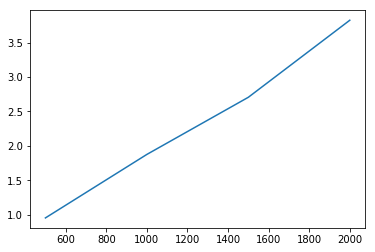

In [34]:
plt.plot([x for x in run_times_base], [np.mean(times) for times in run_times_base.values()])

Next experiment: add the standard data collector and compare

In [153]:
    def collect(self, model):
        """ Collect all the data for the given model object. """
        if self.model_reporters:
            for var, reporter in self.model_reporters.items():
                self.model_vars[var].append(reporter(model))

        if self.agent_reporters:
            for var, reporter in self.agent_reporters.items():
                agent_records = []
                for agent in model.schedule.agents:
                    agent_records.append((agent.unique_id, reporter(agent)))
                self.agent_vars[var].append(agent_records)

In [144]:
    def collect(self, model):
        """ Collect all the data for the given model object. """
        if self.model_reporters:
            for var, reporter in self.model_reporters.items():
                self.model_vars[var].append(reporter(model))

        if self.agent_reporters:
            agents = model.schedule.agents
            for var, reporter in self.agent_reporters.items():
                self.agent_vars[var].append([*map(reporter, agents)])

In [158]:
    def collect(self, model):
        """ Collect all the data for the given model object. """
        if self.model_reporters:
            for var, reporter in self.model_reporters.items():
                self.model_vars[var].append(reporter(model))

        if self.agent_reporters:
            for agent in model.schedule.agents: 
                for var, reporter in self.agent_reporters.items():
                    agent_records = []
                    agent_records.append((agent.unique_id, reporter(agent)))
                    self.agent_vars[var].append(agent_records)

In [159]:
DataCollector.collect = collect

In [172]:
class DCTestModel(BaselineTestModel):
    '''Model with the data collector.'''
    
    def __init__(self, n_agents):
        super().__init__(n_agents)
        self.data_collector = DataCollector(agent_reporters={"x": "x", "y": "y"})
        
    def step(self):
        super().step()
        self.data_collector.collect(self)

In [173]:
model = DCTestModel(10)

In [174]:
model.step()

In [175]:
run_times_dc = run_experiment(DCTestModel, agent_counts, n_runs=1)

In [49]:
def o_collect(self, model):
    """ Collect all the data for the given model object. """
    if self.model_reporters:
        for var, reporter in self.model_reporters.items():
            self.model_vars[var].append(reporter(model))

    if self.agent_reporters:
        for var, reporter in self.agent_reporters.items():
            agent_records = []
            for agent in model.schedule.agents:
                agent_records.append((agent.unique_id, reporter(agent)))
            self.agent_vars[var].append(agent_records)


In [176]:
%%prun

model = DCTestModel(1000)
for _ in range(1000):
    model.step()

         13224512 function calls in 3.408 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  2000000    1.404    0.000    2.058    0.000 random.py:397(normalvariate)
  1000000    0.592    0.000    2.649    0.000 <ipython-input-26-38b2a071b112>:7(step)
  2737500    0.362    0.000    0.362    0.000 {built-in method math.log}
     1000    0.303    0.000    0.465    0.000 <ipython-input-170-b4635458a6e3>:1(collect)
  5477000    0.291    0.000    0.291    0.000 {method 'random' of '_random.Random' objects}
     1000    0.242    0.000    2.891    0.003 time.py:68(step)
  2000000    0.134    0.000    0.134    0.000 {method 'append' of 'list' objects}
     1000    0.045    0.000    0.046    0.000 <ipython-input-26-38b2a071b112>:2(__init__)
     1000    0.028    0.000    0.029    0.000 time.py:80(agents)
     1000    0.003    0.000    2.894    0.003 <ipython-input-27-84928f1c8c03>:10(step)
     1000    0.002    0.000    3.361    0.00

In [151]:
run_times_dc = run_experiment(DCTestModel, agent_counts, n_runs=1)

Text(0,0.5,'Runtime (seconds)')

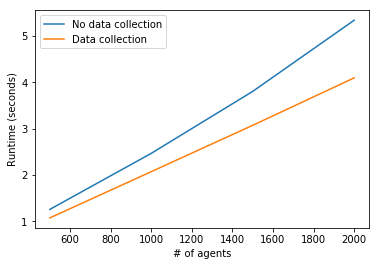

In [177]:
fig, ax = plt.subplots()

ax.plot([x for x in run_times_base], [np.mean(times) for times in run_times_dcO.values()],
       label="No data collection")
ax.plot([x for x in run_times_dc], [np.mean(times) for times in run_times_dc.values()],
       label="Data collection")

ax.legend()
ax.set_xlabel("# of agents")
ax.set_ylabel("Runtime (seconds)")

# Adding SQLite writing

In [13]:
import sqlite3

In [14]:
class SQLiteTestModel(BaselineTestModel):
    '''Model with the data collector.'''
    
    def __init__(self, n_agents):
        super().__init__(n_agents)
        self.conn = sqlite3.connect(":memory:")
        self.c = self.conn.cursor()
        self.c.execute(
            "CREATE TABLE agent_data (turn INTEGER, unique_id REAL, x REAL, y REAL)"
        )
        self.conn.commit()
        self.insert_sql = "INSERT INTO agent_data VALUES (?, ?, ?, ?)"
        
    def step(self):
        super().step()
        self.record_data()
    
    def record_data(self):
        self.c.execute("BEGIN TRANSACTION;")
        values = [(self.schedule.steps, a.unique_id, a.x, a.y) for a in self.schedule.agents]
        self.c.executemany(self.insert_sql, values)
        self.conn.commit()

In [15]:
%%prun

m = SQLiteTestModel(1000)
for _ in range(1000):
    m.step()

         11228435 function calls in 4.138 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  2000000    1.400    0.000    2.065    0.000 random.py:397(normalvariate)
     1000    0.966    0.001    0.966    0.001 {method 'executemany' of 'sqlite3.Cursor' objects}
  1000000    0.604    0.000    2.670    0.000 <ipython-input-2-38b2a071b112>:7(step)
  2737475    0.370    0.000    0.370    0.000 {built-in method math.log}
  5476950    0.295    0.000    0.295    0.000 {method 'random' of '_random.Random' objects}
     1000    0.231    0.000    2.901    0.003 time.py:68(step)
     1000    0.210    0.000    0.210    0.000 <ipython-input-14-2626fd2e5b01>:20(<listcomp>)
     1000    0.027    0.000    0.027    0.000 time.py:80(agents)
     1000    0.013    0.000    4.128    0.004 <ipython-input-14-2626fd2e5b01>:14(step)
     1001    0.003    0.000    0.003    0.000 {method 'commit' of 'sqlite3.Connection' objects}
     1000    0.003   

In [16]:
run_times_sql = run_experiment(SQLiteTestModel, agent_counts, n_runs=1)

Text(0,0.5,'Runtime (seconds)')

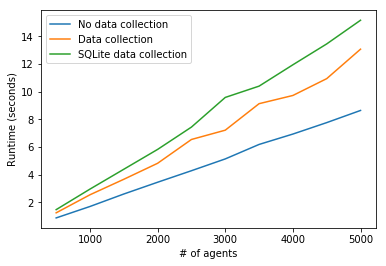

In [17]:
fig, ax = plt.subplots()

ax.plot([x for x in run_times_base], [np.mean(times) for times in run_times_base.values()],
       label="No data collection")
ax.plot([x for x in run_times_dc], [np.mean(times) for times in run_times_dc.values()],
       label="Data collection")

ax.plot([x for x in run_times_sql], [np.mean(times) for times in run_times_sql.values()],
       label="SQLite data collection")


ax.legend()
ax.set_xlabel("# of agents")
ax.set_ylabel("Runtime (seconds)")